In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
from thesis_toolbox.utils import get_locations_CLP,read_depostion_datasets
from thesis_toolbox.plot.tools import add_letter
from thesis_toolbox.plot.plot_source_contribution import depositon_facet_plot
from dust.plot.plotting import mpl_base_map_plot_xr
from dust.plot.maps import map_terrain_china, map_china
from dust.plot.utils import _gen_flexpart_colormap,_add_colorbar
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib
import matplotlib.cm as cm
%matplotlib inline
# latex_plot()

In [2]:
if 'snakemake' in globals():
    to_file = True
    path='./'
else:
    path = '../../../'
    to_file= False

In [3]:
def min_max_norm(ds):
    out_ds = ds.copy()
    for dvar, da in ds.items():
        da = (da-da.min())/(da.max()-da.min())
        out_ds = out_ds.assign({dvar:da})
    return out_ds

In [4]:
def calc_fraction_of_mean_contribution(ds):
    out_ds = ds.copy()
    for dvar, da in ds.items():
        da = da.where(da > 0.0)
        dm = da.mean(skipna=True)
#         da = da.where(da > 0.0)
        da = da/dm
#         da = da.where(da == 1.0, 1.0)
        out_ds = out_ds.assign({dvar:da})
    return out_ds

In [5]:
def calc_ratio(ds_tot, ds_f):
    ds_out = ds_tot.copy()
    for dtvar, dvar in zip(ds_tot,ds_f):
        ds_out = ds_out.assign({dtvar: ds_f[dvar]/ds_tot[dtvar]})
    return ds_out

In [6]:
locs = ['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']
wetdep2m = read_depostion_datasets(path+'results/model_results/', locs, 'wetdep','2micron')
wetdep2m = wetdep2m.mean(dim='year')

drydep2m = read_depostion_datasets(path+'results/model_results/', locs, 'drydep', '2micron')
drydep2m = drydep2m.mean(dim='year')

wetdep20m = read_depostion_datasets(path+'results/model_results/', locs, 'wetdep','20micron')
wetdep20m = wetdep20m.mean(dim='year')

drydep20m = read_depostion_datasets(path+'results/model_results/', locs, 'drydep', '20micron')
drydep20m = drydep20m.mean(dim='year')

In [7]:
ratio_avg2m_wetdep = calc_fraction_of_mean_contribution(wetdep2m)
ratio_avg2m_drydep = calc_fraction_of_mean_contribution(drydep2m)
ratio_avg20m_wetdep = calc_fraction_of_mean_contribution(wetdep20m)
ratio_avg20m_drydep = calc_fraction_of_mean_contribution(drydep20m)

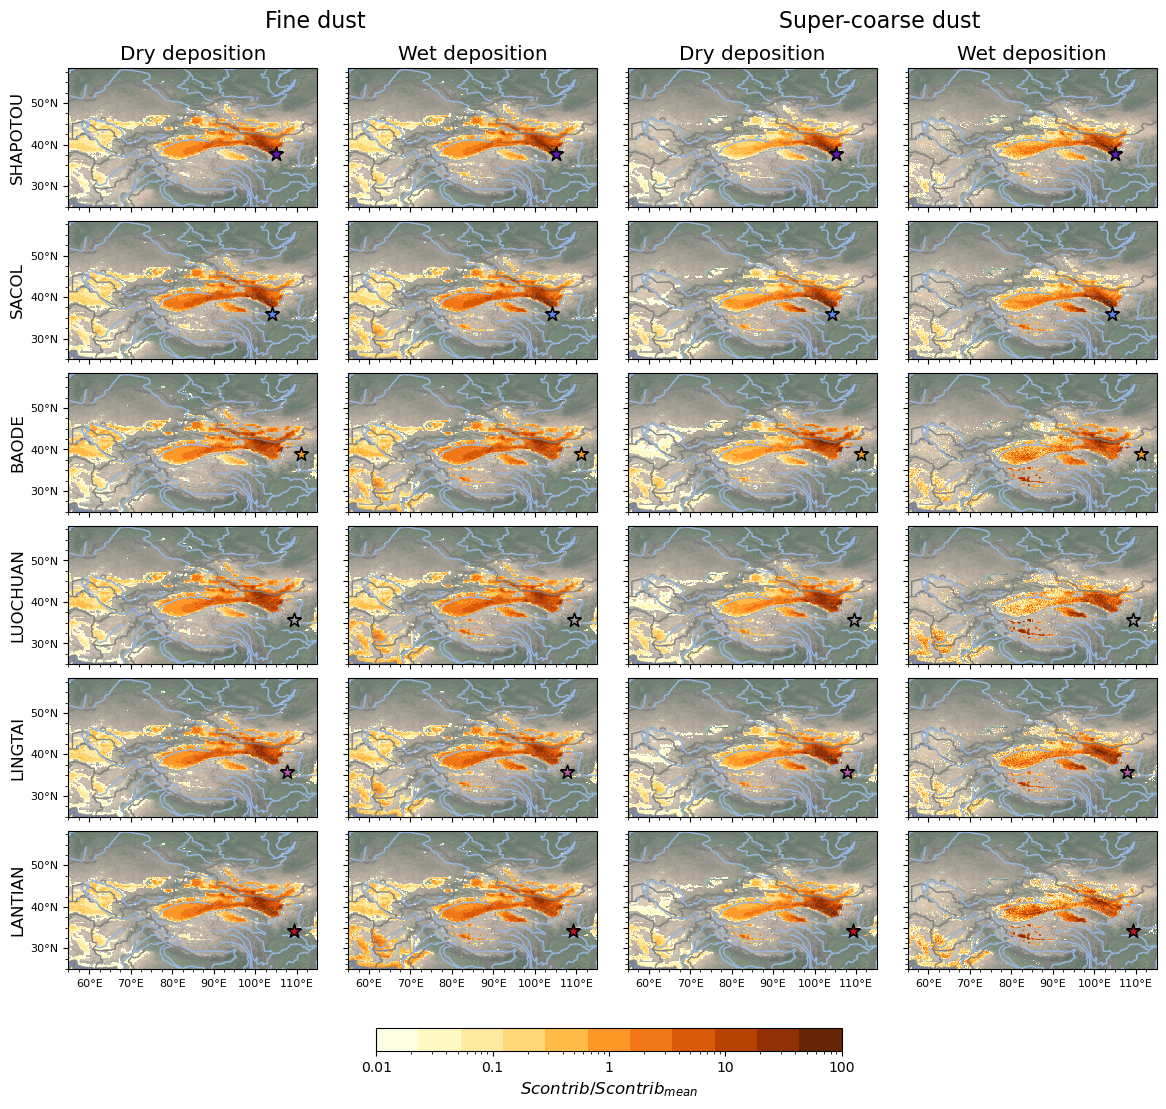

In [9]:
fig,ax = plt.subplots(nrows=6, ncols=4,  figsize=(8.3*1.7, 11.7), subplot_kw={'projection':ccrs.PlateCarree()})


cmap = cm.get_cmap('YlOrBr',11)
depositon_facet_plot(ratio_avg2m_drydep,  
                    add_labels=False, ax=ax[:,0],  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False, norm= matplotlib.colors.LogNorm(1e-2, 100))
depositon_facet_plot(ratio_avg2m_wetdep,  
                    add_labels=False, ax=ax[:,1]
                    ,norm=matplotlib.colors.LogNorm(1e-2, 100),  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False)
cax = fig.add_axes([0.345, 0.04,0.33,0.02])
cb = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1e-2, 100), cmap=cmap), cax=cax,
            label='$Scontrib/ Scontrib_{mean}$', orientation='horizontal', ticks=[0.01, 0.1, 1, 10, 100])
cb.ax.set_xticklabels([0.01, 0.1, 1, 10, 100])
depositon_facet_plot(ratio_avg20m_drydep,  
                    add_labels=False, ax=ax[:,2]
                    , hspace=0.05, wspace=0.1,  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False)
depositon_facet_plot(ratio_avg20m_wetdep,  
                    add_labels=False, ax=ax[:,3]
                    , hspace=0.05, wspace=0.1,  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False)
for axi in ax.ravel():
    axi.set_extent([55,115,25,55])
    axi.set_xticks([60,70, 80, 90, 100, 110])
    axi.yaxis.set_ticklabels([])
    axi.xaxis.set_ticklabels([])
for axi,l in zip(ax[:,0].ravel(),locs):
    axi.set_ylabel(l)
    axi.set_yticks([30, 40, 50])
    axi.yaxis.set_ticklabels(['30°N', '40°N', '50°N'], fontsize=8)

for axi in ax[-1,:].ravel():
    axi.set_xticks([60,70, 80, 90, 100, 110])
    axi.xaxis.set_ticklabels(['60°E','70°E','80°E', '90°E', '100°E', '110°E'], fontsize=8)

fig.suptitle('Fine dust                                                          Super-coarse dust',x=0.52, y=0.92, ha='center', va='center', fontsize=16)

# cax = fig.add_axes([0.55, 0.08,0.33,0.02])
# fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=cmap), cax=cax,
#             label='Fraction of wetdeposition', orientation='horizontal')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax[0,0].set_title('Dry deposition')
ax[0,1].set_title('Wet deposition')
ax[0,2].set_title('Dry deposition')
ax[0,3].set_title('Wet deposition')
# add_letter(ax.T,y=1.07, fontsize=10)
if to_file:
    plt.savefig(snakemake.output.combopath,bbox_inches='tight', dpi=300)
plt.savefig('test.png', dpi=300)